# TP2: Détection de menaces radar

Listez les noms des étudiants (3 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp2.ipynb 

Installez les paquets nécessaires à la réalisation de ce TP
<br> 
Vous pouvez utiliser dans le notebook 
!pip install \<nom_du_paquet\>

## Mission

Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    - train
    - test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'. 

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante: 

    - Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser 
    - Sélection d'un algorithme naïf de référence: vous définissez un premier algorithme ad hoc et à la main et caractérisez ses performances 
    - Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
    - Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"
    
Vous pouvez ouvrir un fichier de la façon suivante:
    

## Load libraries and Google Drive.

In [1]:
# Force Sklearn to don't display warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# Install libraries
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.4 MB/s 


In [82]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
import json
import shap

from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm

from google.colab import drive

In [4]:
# Load Drive to get the data
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Global features
path_train = "/content/drive/MyDrive/ENS MVA/I&I - Signal/TP2/data/train"
path_test = "/content/drive/MyDrive/ENS MVA/I&I - Signal/TP2/data/test"

path_train_labels = "/content/drive/MyDrive/ENS MVA/I&I - Signal/TP2/data/train_labels.json"
path_test_labels = "/content/drive/MyDrive/ENS MVA/I&I - Signal/TP2/data/test_labels.json"

Dans un premier temps, nous chargerons les données (données + labels), et un travail de visualisation de données sera réalisé.

# Load labels

In [6]:
# Load labels of train set
with open(path_train_labels) as f: 
    dict_train_labels = json.load(f)

# Load labels of test set
with open(path_test_labels) as f: 
    dict_test_labels = json.load(f)

## Load a sample to explore data

In [ ]:
# Load a sample data
path_sample_0 = os.path.join(path_train, "pdw-0.npz")
pdws = np.load(path_sample_0)

# Print files of the NPZ object
print("files: ", pdws.files)

files:  ['date', 'largeur', 'frequence', 'puissance', 'theta', 'phi']


### Explore the sample to check how to access data and label

In [ ]:
# Print length and first element, of each features for a given signal

# Available features
column_names = ['date', 'largeur', 'frequence', 'puissance', 'theta', 'phi']

# For each available features
for col in column_names:

  # Print length (number of element for a given signal)
  print("Length for feature ", col, ": ", len(pdws[col]))

  # Print first element
  print("First element for feature ", col, ": ", pdws[col][0], "\n")

# Print label of this signal
print(f"Label of signal pdw-{0}.npz is a: {dict_train_labels[f'pdw-{0}']}")

Length for feature  date :  672
First element for feature  date :  1.31 

Length for feature  largeur :  672
First element for feature  largeur :  0.291 

Length for feature  frequence :  672
First element for feature  frequence :  2.2220113463017723 

Length for feature  puissance :  672
First element for feature  puissance :  -125.58248735699023 

Length for feature  theta :  672
First element for feature  theta :  0.9578859532471261 

Length for feature  phi :  672
First element for feature  phi :  1.678935775441994 

Label of signal pdw-0.npz is a: nonmenace


________________
# Partie 1 : Exploration

## 1.1 - Exploration visuelle pour un signal donné

On représente la largeur, la fréquence, la puissance, theta et phi dans le temps

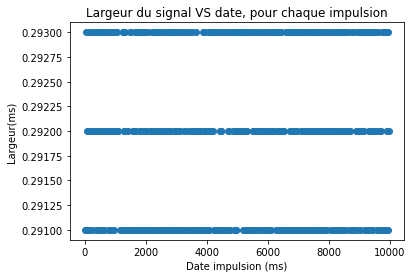

In [ ]:
# Plot date VS largeur
plt.plot(pdws['date'], pdws['largeur'], linestyle="",marker="o");
plt.title('Largeur du signal VS date, pour chaque impulsion');
plt.xlabel('Date impulsion (ms)');
plt.ylabel('Largeur(ms)');

plt.show()

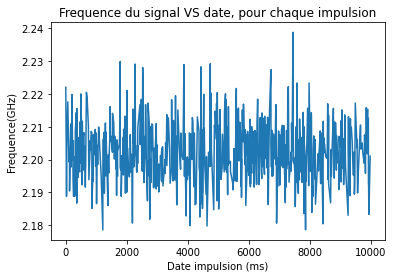

In [ ]:
# Plot date VS frequence
plt.plot(pdws['date'], pdws['frequence']);
plt.title('Frequence du signal VS date, pour chaque impulsion');
plt.xlabel('Date impulsion (ms)');
plt.ylabel('Frequence(GHz)');

plt.show()

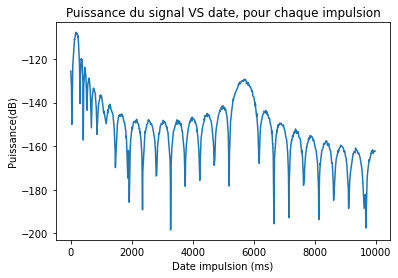

In [ ]:
# Plot date VS puissance
plt.plot(pdws['date'], pdws['puissance']);
plt.title('Puissance du signal VS date, pour chaque impulsion');
plt.xlabel('Date impulsion (ms)');
plt.ylabel('Puissance(dB)');

plt.show()

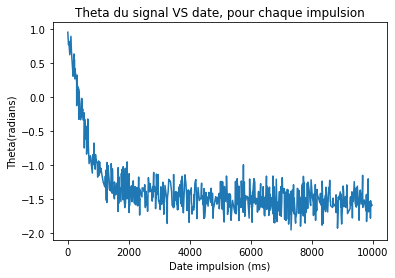

In [ ]:
# Plot date VS theta
plt.plot(pdws['date'], pdws['theta']);
plt.title('Theta du signal VS date, pour chaque impulsion');
plt.xlabel('Date impulsion (ms)');
plt.ylabel('Theta(radians)');

plt.show()

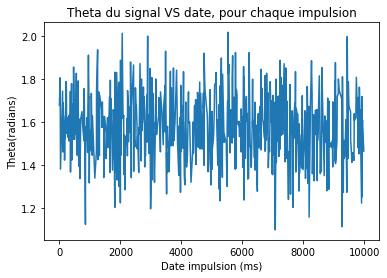

In [ ]:
# Plot date VS phi
plt.plot(pdws['date'], pdws['phi']);
plt.title('Phi du signal VS date, pour chaque impulsion');
plt.xlabel('Date impulsion (ms)');
plt.ylabel('Phi(radians)');

plt.show()

## Load data for every sample

Désormais, un travail sur les données sera réalisé afin de créer le dataset final pour l'entrainement des modèles.

In [12]:
# Lecture des labels pour l'echantillon train, puis test
train_labels, test_labels = [], []

# Train
for i in range(len(dict_train_labels)):
  train_labels.append(dict_train_labels[f'pdw-{i}'])

# Test
for i in range(len(dict_test_labels)):
  test_labels.append(dict_test_labels[f'pdw-{i}'])

Création d'un dictionnaire pour stocker toutes les données de la forme {date:[signal1, signal2...], frequence:[signal1, signal2...] ...}.

In [8]:
# Load data 
dict_train_2, dict_test_2 = {}, {}

dict_train_2['date'], dict_train_2['largeur'], dict_train_2['frequence'] = {}, {}, {}
dict_train_2['puissance'], dict_train_2['theta'], dict_train_2['phi'] = {}, {}, {}
dict_train_2['labels'] = {}

dict_test_2['date'], dict_test_2['largeur'], dict_test_2['frequence'] = {}, {}, {}
dict_test_2['puissance'], dict_test_2['theta'], dict_test_2['phi'] = {}, {}, {}
dict_test_2['labels'] = {}

# TRAIN
for i in range(len(dict_train_labels)):

  # Load current sample
  path_current_sample = os.path.join(path_train, "pdw-"+str(i)+".npz")
  pdws = np.load(path_current_sample)

  # Get features of this sample
  dict_train_2['date'][i] = pdws['date']
  dict_train_2['largeur'][i] = pdws['largeur']
  dict_train_2['frequence'][i] = pdws['frequence']
  dict_train_2['puissance'][i] = pdws['puissance']
  dict_train_2['theta'][i] = pdws['theta']
  dict_train_2['phi'][i] = pdws['phi']

  # Get label
  dict_train_2['labels'][i] = dict_train_labels[f'pdw-{i}']

# TEST
for i in range(len(dict_test_labels)):

  # Load current sample
  path_current_sample = os.path.join(path_test, "pdw-"+str(i)+".npz")
  pdws = np.load(path_current_sample)

  # Get features of this sample
  dict_test_2['date'][i] = pdws['date']
  dict_test_2['largeur'][i] = pdws['largeur']
  dict_test_2['frequence'][i] = pdws['frequence']
  dict_test_2['puissance'][i] = pdws['puissance']
  dict_test_2['theta'][i] = pdws['theta']
  dict_test_2['phi'][i] = pdws['phi']

  # Get label
  dict_test_2['labels'][i] = dict_test_labels[f'pdw-{i}']

# 1.2 - Exploration visuelle du jeu de données

Dans cette partie, on propose de comparer les différentes valeurs des variables, pour chaque label. Afin de voir si des différentes peuvent être facilement observées.

## Exploration des labels

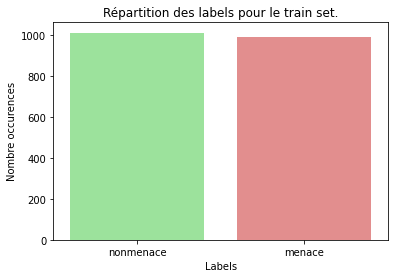

In [13]:
# Pour le train set
sns.countplot(x = train_labels, palette = ['lightgreen', 'lightcoral'])

plt.title("Répartition des labels pour le train set.")
plt.xlabel('Labels')
plt.ylabel('Nombre occurences')

plt.show()

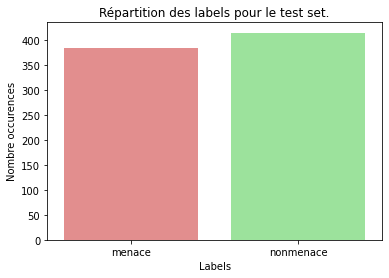

In [14]:
# Pour le test set
sns.countplot(x = test_labels, palette = ['lightcoral', 'lightgreen'])

plt.title("Répartition des labels pour le test set.")
plt.xlabel('Labels')
plt.ylabel('Nombre occurences')

plt.show()

## Exploration des variables pour chaque label

### [1/5] - Fréquence

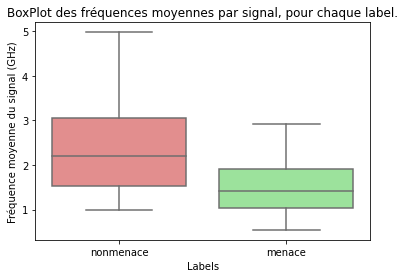

In [15]:
# BoxPlot de la moyenne des fréquences : MENANCE vs NON-MENACE

# Extract data
frequence_train = list(dict_train_2['frequence'].values())
frequence_train_mean = [sum(sub_list) / len(sub_list) for sub_list in frequence_train]

# BoxPlot
sns.boxplot(x = train_labels, y = frequence_train_mean, palette = ['lightcoral', 'lightgreen'])

plt.title("BoxPlot des fréquences moyennes par signal, pour chaque label.")
plt.xlabel('Labels')
plt.ylabel('Fréquence moyenne du signal (GHz)')

plt.show()

In [24]:
# La frequence moyenne d'un signal sera utilisée comme classifier pour la première méthode naive à partir du premier quartile

# Calcul du premier quartile des fréquences moyennes des signaux labelisés (non-menace) du training set
freqence_nonmenance = [frequence_train_mean[i] for i in range(len(train_labels)) if train_labels[i]=="nonmenace"]
threshold_freqence = np.percentile(freqence_nonmenance, 25)

print(f"Le premier quartile des fréquences moyennes des signaux labelisés 'nonmenance' est : {threshold_freqence:.2f} GHz.")

Le premier quartile des fréquences moyennes des signaux labelisés 'nonmenance' est : 1.54 GHz.


### [2/5] - Puissance

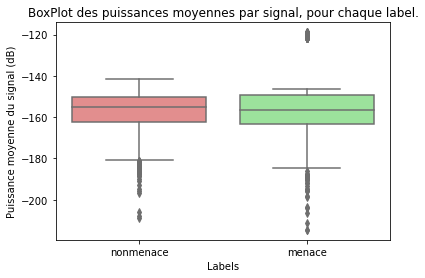

In [ ]:
# BoxPlot de la moyenne des puissances : MENANCE vs NON-MENACE

# Extract data
puissance_train = list(dict_train_2['puissance'].values())
puissance_train_mean = [sum(sub_list) / len(sub_list) for sub_list in puissance_train]

# BoxPlot
sns.boxplot(x = train_labels, y = puissance_train_mean, palette = ['lightcoral', 'lightgreen'])

plt.title("BoxPlot des puissances moyennes par signal, pour chaque label.")
plt.xlabel('Labels')
plt.ylabel('Puissance moyenne du signal (dB)')

plt.show()

### [3/5] - Largeur

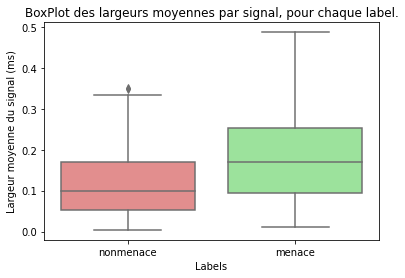

In [60]:
# BoxPlot de la moyenne des largeurs : MENANCE vs NON-MENACE

# Extract data
largeur_train = list(dict_train_2['largeur'].values())
largeur_train_mean = [sum(sub_list) / len(sub_list) for sub_list in largeur_train]

# BoxPlot
sns.boxplot(x = train_labels, y = largeur_train_mean, palette = ['lightcoral', 'lightgreen'])

plt.title("BoxPlot des largeurs moyennes par signal, pour chaque label.")
plt.xlabel('Labels')
plt.ylabel('Largeur moyenne du signal (ms)')

plt.show()

In [61]:
# Calcul du premier quartile des largeur moyennes des signaux labelisés (menace) du training set
largeur_menace = [largeur_train_mean[i] for i in range(len(train_labels)) if train_labels[i]=="menace"]
threshold_largeur = np.percentile(largeur_menace, 25)

print(f"Le premier quartile des fréquences moyennes des signaux labelisés 'menace' est : {threshold_largeur:.2f} ms.")

Le premier quartile des fréquences moyennes des signaux labelisés 'menace' est : 0.09 ms.


### [4/5] - Theta

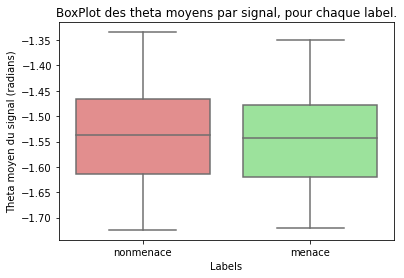

In [ ]:
# BoxPlot de la moyenne des theta : MENANCE vs NON-MENACE

# Extract data
theta_train = list(dict_train_2['theta'].values())
theta_train_mean = [sum(sub_list) / len(sub_list) for sub_list in theta_train]

# BoxPlot
sns.boxplot(x = train_labels, y = theta_train_mean, palette = ['lightcoral', 'lightgreen'])

plt.title("BoxPlot des theta moyens par signal, pour chaque label.")
plt.xlabel('Labels')
plt.ylabel('Theta moyen du signal (radians)')

plt.show()

### [5/5] - Phi

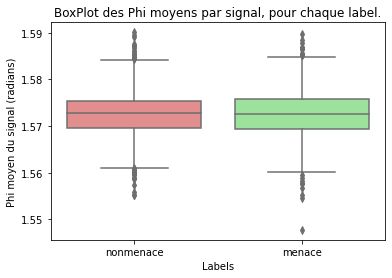

In [ ]:
# BoxPlot de la moyenne des phi : MENANCE vs NON-MENACE

# Extract data
phi_train = list(dict_train_2['phi'].values())
phi_train_mean = [sum(sub_list) / len(sub_list) for sub_list in phi_train]

# BoxPlot
sns.boxplot(x = train_labels, y = phi_train_mean, palette = ['lightcoral', 'lightgreen'])

plt.title("BoxPlot des Phi moyens par signal, pour chaque label.")
plt.xlabel('Labels')
plt.ylabel('Phi moyen du signal (radians)')

plt.show()

## Observations :

2 variables semblent particulièrement discriminantes sur le label du signal (non-manace ou menace) :  la fréquence moyenne et dans un second temps la largeur moyenne. Ainsi, l'algorithme naïf qui sera utilisé est une classification par threshold (*cf TP1*) avec la règle de décision suivante:

- Si la fréquence moyenne du signal est supérieure à 1.539 GHz ⟹ le signal est associé à la classe "non menace".

- Sinon, le signal est associé à la classe menance.

________________

# Partie 2 : Développement du premier algorithme : Algorithme naif avec seuil sur la fréquence moyenne

Le seuil a été déterminé sur l'échantillon d'entraînement, l'algorithme sera testé sur l'échantillon de test.

In [ ]:
# Rappel
print("Le premier quartile des fréquences moyennes des signaux labelisés 'nonmenance' est :", threshold_freqence, " GHz.")

Le premier quartile des fréquences moyennes des signaux labelisés 'nonmenance' est : 1.5394149561715877  GHz.


In [ ]:
# Pour chaque signal du test set, calcul de la fréquence moyenne
frequence_test = list(dict_test_2['frequence'].values())
frequence_test_mean = [sum(sub_list) / len(sub_list) for sub_list in frequence_test]

# Prediction du label via le seuil
prediction = abs(1-1*(frequence_test_mean>threshold_freqence))

Création d'un dataframe avec 2 colonnes : Pour chaque signal, le label des échantillons de test et la valeur moyenne de la fréquence.

In [ ]:
# Pour chaque signal du test set, calcul de la fréquence moyenne
frequence_test = list(dict_test_2['frequence'].values())
frequence_test_mean = [sum(sub_list) / len(sub_list) for sub_list in frequence_test]

# Prediction du label via le seuil
prediction = abs(1-1*(frequence_test_mean>threshold_freqence))

# Switch des labels : string en integer
test_labels = abs(1-pd.factorize(test_labels)[0])

# Création du dataframe avec 3 colonnes
df = pd.DataFrame({"labels": test_labels, 
                   "freq_mean": frequence_test_mean,
                   "prediction": prediction})

# Calcul de la précision sur la classe 1
print('Precision: %.3f' % precision_score(df.labels, df.prediction))

# Calcul du recall sur la classe 1
print('Recall: %.3f' % recall_score(df.labels, df.prediction))

# Calcul de la précision sur la classe 1
print('Accuracy: %.3f' % accuracy_score(df.labels, df.prediction))

Precision: 0.679
Recall: 0.543
Accuracy: 0.656


Le score à battre est donc de **0.656**.

________________
# Partie 3 : Algorithme d'apprentissage

## 3.1 - Preprocessing

Dans cette partie, on va faire un choix sur les variables à garder dans le modèle, on va créer de nouvelles variables pour enrichir l'information.

Pour rappel les variables disponibles sont : **date, largeur, puissance, fréquence, theta** et **phi** du signal.

Pour chaque signal, on a plusieurs impulsions. Donc pour chaque variable et chaque impulsion, on a une valeur. Par exemple le signal 0 du train set a 672 impulsions. Pour les 6 variables du dessus : 672*6 = 4032 valeurs sont disponibles. On ne peut pas utiliser 4032 variables d'entrée pour un modèle, d'où l'importance du pre-processing.

Première intuition : Pour chaque variable et chaque signal, calculer la moyenne et l'écart-type. 

Seconde intuition : pour chaque signal, on ajoute le pourcentage d'impulsion dont la largeur est supérieure à 0.09ms, et le pourcentage d'impulsion dont la fréquence est supérieure à 1.54GHz. Car j'estime que ces seuils sont descriminants sur la nature du signal (cf DataViz).

In [73]:
# TRAIN
# Pour chaque variable, calcul de la moyenne et de l'écart type
# Largeur
largeur_train_mean, largeur_train_std = [], []
largeur_train = list(dict_train_2['largeur'].values())
for signal in largeur_train:
  largeur_train_mean.append(np.mean(signal))
  largeur_train_std.append(np.std(signal))

# Puissance
puissance_train_mean, puissance_train_std = [], []
puissance_train = list(dict_train_2['puissance'].values())
for signal in puissance_train:
  puissance_train_mean.append(np.mean(signal))
  puissance_train_std.append(np.std(signal))

# Frequence
frequence_train_mean, frequence_train_std = [], []
frequence_train = list(dict_train_2['frequence'].values())
for signal in frequence_train:
  frequence_train_mean.append(np.mean(signal))
  frequence_train_std.append(np.std(signal))

# Theta
theta_train_mean, theta_train_std = [], []
theta_train = list(dict_train_2['theta'].values())
for signal in theta_train:
  theta_train_mean.append(np.mean(signal))
  theta_train_std.append(np.std(signal))

# Phi
phi_train_mean, phi_train_std = [], []
phi_train = list(dict_train_2['phi'].values())
for signal in phi_train:
  phi_train_mean.append(np.mean(signal))
  phi_train_std.append(np.std(signal))

# More feature (try)
largeur_train_countSup = [] # % d'impulsion dont la largeur > 0.09ms
for signal in largeur_train:
  largeur_train_countSup.append(np.sum(signal>threshold_largeur)/len(signal))

frequence_train_countSup = [] # % d'impulsion dont la frequence > 1.54GHz
for signal in frequence_train:
  frequence_train_countSup.append(np.sum(signal>threshold_freqence)/len(signal))

train = pd.DataFrame({'largeur_mean': largeur_train_mean,
                     'largeur_std': largeur_train_std,
                     'puissance_mean': puissance_train_mean,
                     'puissance_std': puissance_train_std,
                     'frequence_mean': frequence_train_mean,
                     'frequence_std': frequence_train_std,
                     'theta_mean': theta_train_mean,
                     'theta_std': theta_train_std,
                     'phi_mean': phi_train_mean,
                     'phi_std': phi_train_std,
                      "largeur_countSup": largeur_train_countSup,
                      "frequence_countSup": frequence_train_countSup}
                     )

In [117]:
# TEST
# Pour chaque variable, calcul de la moyenne et de l'écart type
# Largeur
largeur_test_mean, largeur_test_std = [], []
largeur_test = list(dict_test_2['largeur'].values())
for signal in largeur_test:
  largeur_test_mean.append(np.mean(signal))
  largeur_test_std.append(np.std(signal))

# Puissance
puissance_test_mean, puissance_test_std = [], []
puissance_test = list(dict_test_2['puissance'].values())
for signal in puissance_test:
  puissance_test_mean.append(np.mean(signal))
  puissance_test_std.append(np.std(signal))

# Frequence
frequence_test_mean, frequence_test_std = [], []
frequence_test = list(dict_test_2['frequence'].values())
for signal in frequence_test:
  frequence_test_mean.append(np.mean(signal))
  frequence_test_std.append(np.std(signal))

# Theta
theta_test_mean, theta_test_std = [], []
theta_test = list(dict_test_2['theta'].values())
for signal in theta_test:
  theta_test_mean.append(np.mean(signal))
  theta_test_std.append(np.std(signal))

# Phi
phi_test_mean, phi_test_std = [], []
phi_test = list(dict_test_2['phi'].values())
for signal in phi_test:
  phi_test_mean.append(np.mean(signal))
  phi_test_std.append(np.std(signal))

# More feature (try)
largeur_test_countSup = [] # % d'impulsion dont la largeur > 0.09ms
for signal in largeur_test:
  largeur_test_countSup.append(np.sum(signal>threshold_largeur)/len(signal))

frequence_test_countSup = [] # % d'impulsion dont la frequence > 1.54GHz
for signal in frequence_test:
  frequence_test_countSup.append(np.sum(signal>threshold_freqence)/len(signal))

test = pd.DataFrame({'largeur_mean': largeur_test_mean,
                     'largeur_std': largeur_test_std,
                     'puissance_mean': puissance_test_mean,
                     'puissance_std': puissance_test_std,
                     'frequence_mean': frequence_test_mean,
                     'frequence_std': frequence_test_std,
                     'theta_mean': theta_test_mean,
                     'theta_std': theta_test_std,
                     'phi_mean': phi_test_mean,
                     'phi_std': phi_test_std,
                      "largeur_countSup": largeur_test_countSup,
                      "frequence_countSup": frequence_test_countSup}
                     )

In [76]:
# HEADER du train set
train.head(5)

,largeur_mean,largeur_std,puissance_mean,puissance_std,frequence_mean,frequence_std,theta_mean,theta_std,phi_mean,phi_std,largeur_countSup,frequence_countSup
0,0.292003,0.000829,-151.168286,14.271022,2.202149,0.008909,-1.334458,0.477428,1.574437,0.155398,1.0,1.0
1,0.137017,0.000810,-152.733649,11.655734,2.996037,0.012328,-1.634125,0.347991,1.570940,0.161758,1.0,1.0
2,0.201962,0.000824,-171.253159,12.164566,0.986435,0.004003,-1.607840,0.163853,1.571787,0.154042,1.0,0.0
3,0.069014,0.000813,-149.829714,9.564745,1.665592,0.006610,-1.690380,0.213341,1.585633,0.162123,0.0,1.0
4,0.324018,0.000813,-177.214144,11.162828,2.205039,0.008529,-1.559266,0.674727,1.578277,0.161913,1.0,1.0


In [77]:
# HEADER du test set
test.head(5)

,largeur_mean,largeur_std,puissance_mean,puissance_std,frequence_mean,frequence_std,theta_mean,theta_std,phi_mean,phi_std,largeur_countSup,frequence_countSup
0,0.248983,0.000826,-160.921450,11.724719,1.262377,0.005093,-1.477350,0.242598,1.573885,0.156412,1.0,0.000000
1,0.274015,0.000826,-120.776315,7.368963,0.936235,0.053998,-1.696853,0.267298,1.569615,0.168013,1.0,0.000000
2,0.279004,0.000821,-160.235629,12.154872,1.334002,0.004976,-1.594954,0.163443,1.564593,0.155565,1.0,0.000000
3,0.129001,0.000822,-153.211649,12.312571,1.537033,0.006161,-1.536377,0.337959,1.587882,0.159290,1.0,0.349858
4,0.189011,0.000832,-150.195466,12.192627,1.928637,0.007866,-1.606203,0.197474,1.572989,0.150520,1.0,1.000000


## 3.2 - Training

Une fois les jeux de données créés, il s'agit d'entrainer plusieurs modèles de classification sur le training set. Dans la partie 3.3, les modèles seront testés sur l'échantillon de test, afin de comparer ces modèles.

Dans cette partie, les modèles entraînés sont les suivants : **SVM, Régression logistique, randomForest Classifier et un Multi-Layer Perceptron**.

In [112]:
# Split train into train/validation sets to fine-tune hyper-parameters
train['labels'] = train_labels
train, validation = train_test_split(train, test_size=0.2, random_state=2022)

# Get labels as list like previously
train_labels = train['labels']
validation_labels = validation['labels']

# Remove labels columns
train.drop('labels', axis=1, inplace=True)
validation.drop('labels', axis=1, inplace=True)

In [120]:
# Switch des variables au bon format pour scikit-learn

# Dataframe to numpy
X_train = train.to_numpy()
X_val = validation.to_numpy()
X_test = test.to_numpy()

# Switch des labels : string en integer
y_train = pd.factorize(train_labels)[0]
y_validation = pd.factorize(validation_labels)[0]
y_test = abs(1-pd.factorize(test_labels)[0])

In [127]:
#########################
### Support Vector Machine (SVM) with GridSearch Cross-Validation (HyperParameters tuning)
param_grid = {'C': [0.1,1, 10, 100], 
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'sigmoid']}
grid_svm = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=0)
grid_svm.fit(X_train, y_train)

#########################
### Logistic Regression
clf_regLog = LogisticRegression(random_state=0).fit(X_train, y_train)

#########################
### randomForest Classifier with GridSearch Cross-Validation (HyperParameters tuning)
# List of values to try for each parameter
param_grid = {
    'max_depth': [5, 10, 20],
    'max_features': [2, 5, 10, 20],
    'n_estimators': [100, 200, 300, 500]
}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=0)
grid_rf.fit(X_train, y_train)

#########################
### Multi-Layer Perceptron Classifier
# lbfgs solver since the dataset is small
clf_Percep = MLPClassifier(solver='lbfgs', alpha=1e-2,
                   hidden_layer_sizes=(100, 10), random_state=1)
clf_Percep.fit(X_train, y_train)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, 10), random_state=1,
              solver='lbfgs')

## 3.3 - Validation (hyper parameters tuning)

Une fois les modèles entrainés, on teste les 2 modèles pour le randomForest et pour le SVM qui ont les meilleurs performances sur l'échantillon train, sur l'échantillon de validation. Afin de voir si les modèles généralisent bien ou non, en fonction des valeurs des hyper-paramètres.

On se contente de tester seulement pour 2 modèles par soucis de simplicité et d'efficacité. En pratique, l'idéal serait de tester pour chacun des modèles avec des valeurs d'hyper-paramètres différents.

In [126]:
####### RandomForest
results = pd.DataFrame(grid_rf.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
grid_rf_1 = results.loc[0, 'params']
grid_rf_2 = results.loc[1, 'params']
clf_rf_1 = grid_rf.best_estimator_.set_params(**grid_rf_1)
clf_rf_2 = grid_rf.best_estimator_.set_params(**grid_rf_2)

# randomForest 1
y_pred = clf_rf_1.predict(X_val)
print("randomForest1 on VALIDATION set - Accuracy : ", accuracy_score(y_validation, y_pred))
# randomForest 2
y_pred = clf_rf_2.predict(X_val)
print("randomForest2 on VALIDATION set - Accuracy : ", accuracy_score(y_validation, y_pred))

####### SVM
results = pd.DataFrame(grid_svm.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
grid_svm_1 = results.loc[0, 'params']
grid_svm_2 = results.loc[1, 'params']
clf_svm_1 = grid_svm.best_estimator_.set_params(**grid_svm_1)
clf_svm_2 = grid_svm.best_estimator_.set_params(**grid_svm_2)

# SVM 1
y_pred = clf_svm_1.predict(X_val)
print("SVM1 on VALIDATION set - Accuracy : ", accuracy_score(y_validation, y_pred))
# SVM 2
y_pred = clf_svm_2.predict(X_val)
print("SVM2 on VALIDATION set - Accuracy : ", accuracy_score(y_validation, y_pred))

randomForest1 on VALIDATION set - Accuracy :  0.839041095890411
randomForest2 on VALIDATION set - Accuracy :  0.839041095890411
SVM1 on VALIDATION set - Accuracy :  0.4828767123287671
SVM2 on VALIDATION set - Accuracy :  0.4828767123287671


A la fois pour le randomForest et le SVM, les 2 meilleurs modèles semblent aussi bien généralisés que l'autre sur l'échantillon de validation. Ainsi, on gardera le meilleur sur l'échantillon train pour ces 2 modèles.

## 3.3 - Test

Une fois les modèles entrainés sur l'échantillon train et l'hyper-parameter tuning réalisé, on teste les 4 modèles sur l'échantillon de test afin de voir quel est le plus performant sur des nouvelles données.

In [128]:
# SVM
y_pred = grid_svm.predict(X_test)
print("SVM Tuned - Accuracy : ", accuracy_score(y_test, y_pred))

# Regression Logistic
y_pred = clf_regLog.predict(X_test)
print("Logictic Regression - Accuracy : ", accuracy_score(y_test, y_pred))

# randomForest
y_pred = grid_rf.predict(X_test)
print("RF Tuned - Accuracy : ", accuracy_score(y_test, y_pred))

# Multi-Layer Perceptron
y_pred = clf_Percep.predict(X_test)
print("Multi-Layer Perceptron (100, 10) - Accuracy : ", accuracy_score(y_test, y_pred))

SVM Tuned - Accuracy :  0.80375
Logictic Regression - Accuracy :  0.76
RF Tuned - Accuracy :  0.835
Multi-Layer Perceptron (100, 10) - Accuracy :  0.72625


Le modèle qui présente la meilleur Accuracy sur l'échantillon de test est le **randomForest** avec 83.5% de précision. Autrement dit, 83.5% des prédictions du modèle sont correctes.

C'est le modèle retenu.

________________
# Partie 4 : Interprétation des modèles

Une fois le modèle final choisi, il est intéressant d'analyser ce modèle pour essayer de comprendre comment il fonctionne, pour contrer l'effet **black-box**. Autrement dit, *quelles sont les variables que le modèle identifie comme déterminantes dans la prédiction réalisée ?*

<br>

Pour cela, on propose de travailler sur l'explicabilité d'un modèle via les **SHAP values**.

La valeur **SHAP** nous aide à quantifier la contribution d'une variable à une prédiction. Une valeur **SHAP** proche de zéro signifie que la caractéristique contribue peu à la prédiction, tandis qu'une valeur **SHAP** éloignée de zéro indique que la caractéristique contribue davantage.

<br>

*La documentation : https://shap.readthedocs.io/en/latest/index.html*

<br>

Dans la réalité, lorsqu'on identifie un signal comme une menace, on peut alors utiliser cette méthode pour essayer de comprendre pourquoi le modèle a identifié ce signal comme une menace. Cela permet de **rationaliser** la prise de décision, avec l'avis d'un expert métier. Cela permet, par exemple, de vérifier si le signal reçu n'est pas une anomalie.

## 4.1 - Contribution globale de chaque variable pour la classe positive

Ci-dessous, on représente l'influence moyenne de chaque variable sur la sortie du modèle. Pour cela, on calcule les shap values pour chaque prédiciction de l'échantillon de test (*pour chaque sample, on récupère les shap values pour chacune des variables*) et on calcule la moyenne des shap values obtenues sur toutes les variables.

<br>

La comparaison est réalisée par rapport à la moyenne des labels de l'échantillon de test (49.4% de classe 1/menace).

In [129]:
# Get best parameters of the random Forest classifier
print(f"Best parameters for randomForest classifier: {grid_rf.best_params_}")

Best parameters for randomForest classifier: {'max_depth': 5, 'max_features': 5, 'n_estimators': 100}


In [130]:
# Interpret randomForest classifier model
model = RandomForestClassifier(max_depth= 20, max_features= 2, n_estimators= 200)
model.fit(X_train, y_train)

explainer = shap.Explainer(model)
shap_test = explainer(test)

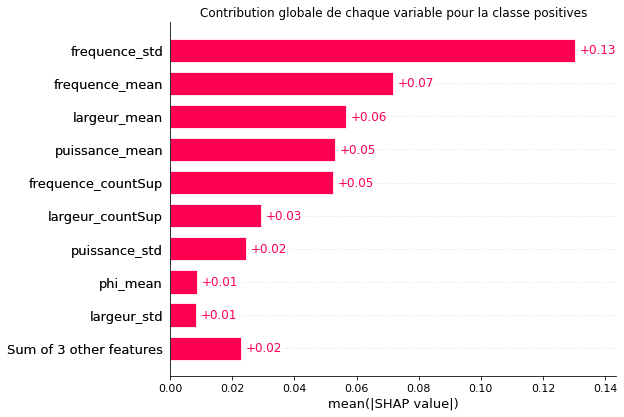

In [131]:
# Contribution globale de chaque variable pour la classe positive
shap.plots.bar(shap_test[:,:,1], show=False)
plt.title("Contribution globale de chaque variable pour la classe positives")
plt.show()

## 4.2 - Contribution de chaque variable pour une prédiction

Il est également possible, lorsqu'une prédiction est réalisée sur un signal donné, d'observer les shap values obtenues pour ce signal. C'est à dire la contribution de chaque variable pour la prédiction de ce signal.

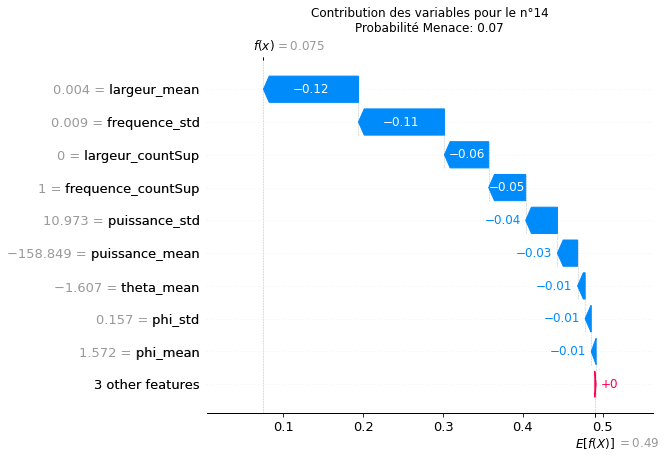

In [132]:
# Contribution des variables pour un signal donné

# Indice du signal à étudier de l'échantillon de test (800 lignes)
indice_signal = 14 # A choisir arbitrairement (range : 0 - 799)

# Waterfall plot : Influence de chaque variable
shap.plots.waterfall(shap_test[:, :, 1][indice_signal], show=False)
plt.title(f"Contribution des variables pour le n°{indice_signal}\nProbabilité Menace: {model.predict_proba(X_test)[indice_signal][1]:.2f}")
plt.show()

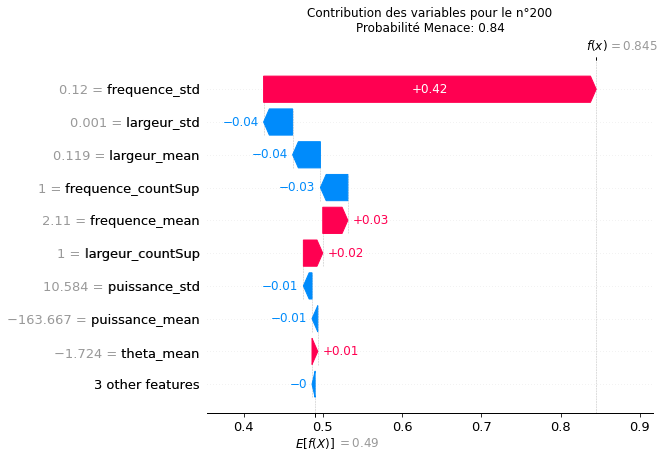

In [133]:
# Second exemple d'interprétation.

# Indice du signal à étudier de l'échantillon de test (800 lignes)
indice_signal = 200 # A choisir arbitrairement (range : 0 - 799)

# Waterfall plot : Influence de chaque variable
shap.plots.waterfall(shap_test[:, :, 1][indice_signal], show=False)
plt.title(f"Contribution des variables pour le n°{indice_signal}\nProbabilité Menace: {model.predict_proba(X_test)[indice_signal][1]:.2f}")
plt.show()

Ici représentée en rouge, **l'écart-type des fréquences** du signal a tendance à augmenter la probabilité que le signal soit une menace.

## Conclusion

Ce TP m'a permis de prendre en main les différents modules de Machine Learning pour des problématiques de classification.

J'ai pu comprendre les difficultés dans la modélisation d'un signal lorsque celui-ci est constitué de centaines d'impulsions. Il faut faire appel à des méthodes de feature engineering et à son intuition. La moyenne et écart-type sont les variables les plus simples à calculer, qui apportent beaucoup d'informations sur le signal.

Pour aller plus loin, j'aurai souhaité utiliser différentes notions vues en cours propres au signal (par exemple diagramme de rayonnement) afin d'améliorer les performances du modèles. C'est une piste d'amélioration pour ce TP, et les prochains à venir.

________________
# FIN du TP 2 - I&I Signal.

## Merci pour votre lecture.

### Théo Di Piazza (MVA)
________________